---
title: "Modeling DAU, WAU, MAU with Markov chain (WIP)"
date: "2024-11-11"
categories: [product analytics, predictive analytics]
draft: false
---

## 1. Introduction 

Doubtlessly, DAU, WAU, and MAU are critical business metrics. An article ["How Duolingo reignited user growth"](https://www.lennysnewsletter.com/p/how-duolingo-reignited-user-growth) by [Jorge Mazal](https://www.linkedin.com/in/jorgemazal/), former CPO of Duolingo is #1 the Growth section of Lenny's Newsletter blog. In this article Jorge payed special attention to the methodology Duolingo used to model DAU metrics (see another article ["Meaningful metrics: how data sharpened the focus of product teams"](https://blog.duolingo.com/growth-model-duolingo/) by [Erin Gustafson](https://blog.duolingo.com/author/erin/)). This methodology has multiple strenghts but I focus here on how one can use it for DAU forecasting.

New year is coming soon, so many companies are planning their budgets for the next year these days. Cost estimations are often require DAU forecast. In this article I'll show you how you can get this prediction using the Duolingo's growth model and share a DAU & MAU "calculator" designed as a Google Spreadsheet calculator.

## 2. Methodology

A quick recap on how the [Duolingo's growth model](https://blog.duolingo.com/growth-model-duolingo/) works. At day $d$ ($d=1,2,\ldots,$) of a user's lifetime the user can be in one of the following 7 (mutually-exclusive) states:

<table class="caption-top table">
<thead><tr class="header"><th>state</th><th width=120>d = 1</th><th width=120>active<br/>today</th><th width=120>active in<br/>[d-6, d-1]</th><th width=120>active in<br/>[d-29, d-7]</th><th width=150>active<br/>before d-30</th></tr></thead>
<tr><td>new</td><td>✅</td><td>❓</td><td>❌</td><td>❌</td><td>❌</td></tr>
<tr><td>current</td><td>❌</td><td>✅</td><td>✅</td><td>❓</td><td>❓</td></tr>
<tr><td>reactivated</td><td>❌</td><td>✅</td><td>❌</td><td>✅</td><td>❓</td></tr>
<tr><td>resurrected</td><td>❌</td><td>✅</td><td>❌</td><td>❌</td><td>✅</td></tr>
<tr><td>at_risk_wau</td><td>❌</td><td>❌</td><td>✅</td><td>❓</td><td>❓</td></tr>
<tr><td>at_risk_mau</td><td>❌</td><td>❌</td><td>❌</td><td>✅</td><td>❓</td></tr>
<tr><td>dormant</td><td>❌</td><td>❌</td><td>❌</td><td>❌</td><td>✅</td></tr>
</table>

Having these states defined (as set $S$), we can consider a user's lifetime trajectory as a Markov chain. Let $M$ be a transition matrix associated with this Markov chain: $m_{i, j} = P(s_j | s_i)$ are the probabilities that a user moves to state $s_j$ right after being at state $s_i$, $s_i, s_j \in S$. The matrix values are easily fetched from the historical data.

If we assume that the user behavior is stationary, the matrix $M$ fully describes states of the all users in the future. Suppose that vector $u_0$ of length 7 contains the counts of users being in certain states at some calendar day denoted as 0. Thus, according to the Markov model, in the next day $u_1$ we expect to have the following amount of users:

$$
\underbrace{
\begin{pmatrix}  \#New_1 \\ \#Current_1 \\ \#Reactivated_1 \\ \#Resurrected_1 \\ \#AtRiskWau_1 \\ \#AtRiskMau_1 \\ \#Dormant_1 \end{pmatrix}
}_{u_1} = M^T \cdot 
\underbrace{
\begin{pmatrix}  \#New_0 \\ \#Current_0 \\ \#Reactivated_0 \\ \#Resurrected_0 \\ \#AtRiskWau_0 \\ \#AtRiskMau_0 \\ \#Dormant_0 \end{pmatrix}
}_{u_0}
$$

Applying this formula recursevely, we derive the amount of the users at any arbitrary day $t > 0$ in the future. The only thing we need to provide despite of the initial distribution $u_0$ is to the amount of new users that would appear in the product each day in the future. We'll get it by using historical data on new users appeared in the past and appyling the [prophet](http://facebook.github.io/prophet/) library.

Now, having $u_t$ calculated, we can calculate DAU values at day t:
$$DAU_t = \#New_t + \#Current_t + \#Reactivated_t +\#Resurrected_t.$$

Additionally, we can easily calculate WAU and MAU metrics:
$$WAU_t = DAU_t +\#AtRiskWau_t,$$
$$MAU_t = DAU_t +\#AtRiskWau_t + \#AtRiskMau_t.$$

Finally, the algorithm looks like this:


1. For each prediction day $t=1, ..., T$ calculate the expected amount of new users $\#New_1, \ldots, \#New_T$.
2. For each lifetime day of each user define on of the 7 states.
3. Calculate the transition matrix $M$.
4. Calculate initial counts $u_0$ corresponding to $t=0$ day.
5. Calculate recursively $u_{t+1} = M^T u_t$.
6. Calculate DAU, WAU, MAU for each prediction day $t=1, ..., T$.

## 3. Implementation

### 3.1 Dataset

We use a simulated dataset based on historical data of a SAAS app. The data is stored in the `dau_data.csv.gz` file and contains three columns: `user_id`, `date`, and `registration_date`. Each record indicates a day when a user was active.

The data includes activity indicators for all users from `2020-11-01` to `2022-10-31`. An additional month, October 2020, is included to calculate user states correctly (`at_risk_mau` and `dormant` states require data from one month prior).

In [1]:
import pandas as pd

df = pd.read_csv('dau_data.csv.gz', compression='gzip')
df['date'] = pd.to_datetime(df['date'])
df['registration_date'] = pd.to_datetime(df['registration_date'])

print(f'Shape: {df.shape}')
print(f'Total users: {df['user_id'].nunique()}')
print(f'Data range: [{df['date'].min()}, {df['date'].max()}]')
df.head()

Shape: (447048, 3)
Total users: 38093
Data range: [2020-10-01 00:00:00, 2022-10-31 00:00:00]


,user_id,date,registration_date
0,7a010840-b4d1-543d-bd4c-fbb4ae2198c5,2020-10-01,2020-08-26
1,d565a211-1996-538b-b067-11a38616c8cf,2020-10-01,2020-10-01
2,41fb29c7-8122-59db-a690-e9d9502f3c38,2020-10-01,2020-09-02
3,310c15a2-fe92-5703-be1f-80270c1b83bd,2020-10-01,2020-08-27
4,234c3035-145f-5694-bd7f-bec58a5f0c5c,2020-10-01,2020-05-31


This is how the DAU time-series looks like up to 2022-10-31.

<Axes: title={'center': 'DAU, historical'}, xlabel='date'>

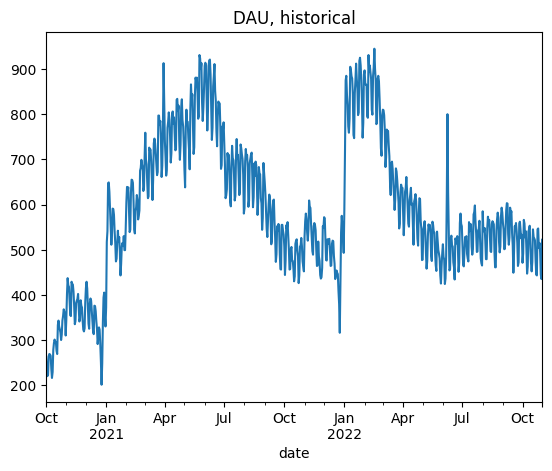

In [2]:
df.groupby('date').size()\
    .plot(title='DAU, historical')

Suppose that today is 2022-10-31 and we want to predict the DAU metric for the next 2023 year. We define a couple of constants `PREDICTION_START` and `PREDICTION_END` which define the prediction period.

In [3]:
PREDICTION_START = '2022-11-01'
PREDICTION_END = '2023-12-31'

### 3.2 Predicting new users amount

Let's start from the new users prediction. We use the `prophet` library as one of the easiest ways to predict time-series data. The `new_users` Series contains such data. We extract it from the original `df` dataset selecting the rows where the registration date is equal to the date.

In [4]:
#| code-fold: true
#| code-summary: Toggle the code

new_users = df[df['date'] == df['registration_date']]\
    .assign(date=pd.to_datetime(df['date']))\
    .groupby('date').size()

In [5]:
new_users.head()

date
2020-10-01    4
2020-10-02    3
2020-10-03    3
2020-10-04    4
2020-10-05    8
dtype: int64

`prophet` requires a time-series as a DataFrame containing two columns `ds` and `y`, so we reformat the `new_users` Series to the `new_users_prophet` DataFrame. Another thing we need to prepare is to create the `future` variable containing certain days for prediction: from `PREDICTION_START` to `PREDICTION_END`. The plot illustrates predictions for both past and future dates.

/Users/v.kukushkin/Documents/private/wowone.github.io/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
01:09:22 - cmdstanpy - INFO - Chain [1] start processing
01:09:22 - cmdstanpy - INFO - Chain [1] done processing


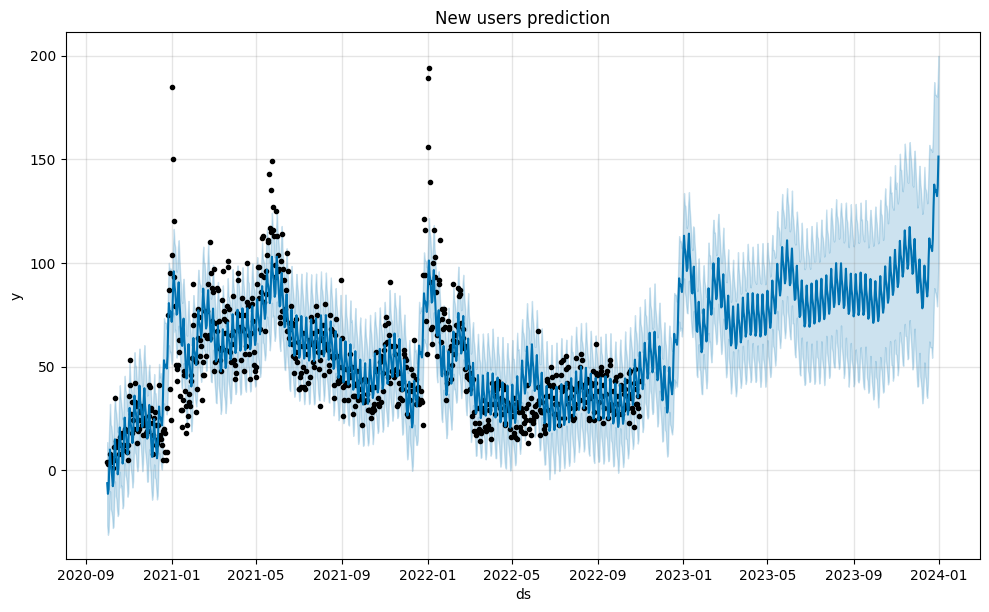

In [6]:
#| code-fold: true
#| code-summary: Toggle the code

import matplotlib.pyplot as plt
from prophet import Prophet

m = Prophet()
new_users_prophet = pd.DataFrame({'ds': new_users.index, 'y': new_users.values})
m.fit(new_users_prophet)

periods = len(pd.date_range(PREDICTION_START, PREDICTION_END))
future = m.make_future_dataframe(periods=periods)
new_users_pred = m.predict(future)
m.plot(new_users_pred)
plt.title('New users prediction');

new_users_pred = new_users_pred\
    .assign(yhat=lambda _df: _df['yhat'].astype(int))\
    .rename(columns={'ds': 'date', 'yhat': 'count'})\
    .set_index('date')\
    .clip(lower=0)\
    ['count']

The `new_users_pred` Series keeps the predicted users amount.

In [7]:
new_users_pred.tail(5)

date
2023-12-27    135
2023-12-28    134
2023-12-29    132
2023-12-30    137
2023-12-31    151
Name: count, dtype: int64

### 3.3 Getting the states

In practice, the most calculations are reasonable to execute as SQL queries to a database where the data is stored. Hereafter, we will simulate such quering with the `duckdb` library.

We want to assign one of the 7 states to each day of a user's lifetime within the app. According to the definition, for each day, we need to consider at least the past 30 days. This is where SQL window functions come in. However, since the `df` data contains only records of *active days*, we need to explicitly extend it to include the days when a user was not active. In other words, instead of this list of records:

```
user_id    date          registration_date
1234567    2022-01-01    2022-01-01
1234567    2022-01-03    2022-01-01
```

we'd like to get a list like this:

```
user_id    date          is_active    registration_date
1234567    2022-01-01    TRUE         2022-01-01
1234567    2022-01-02    FALSE        2022-01-01
1234567    2022-01-03    TRUE         2022-01-01
1234567    2022-01-04    FALSE        2022-01-01
1234567    2022-01-05    FALSE        2022-01-01
...        ...           ...          ...
1234567    2022-10-31    FALSE        2022-01-01
```

For readability purposes we split the following SQL query into multiple subqueries.

- `full_range`: Create a full sequence of dates for each user.
- `dau_full`: Get the full list of both active and inactive records.
- `states`: Assign one of the 7 states for each day of a user's lifetime.

In [8]:
#| code-fold: true
#| code-summary: Toggle the code

import duckdb

DATASET_START = '2020-11-01'
DATASET_END = '2022-10-31'
OBSERVATION_START = '2020-10-01'

query = f"""
WITH
full_range AS (
    SELECT
        user_id, UNNEST(generate_series(greatest(registration_date, '{OBSERVATION_START}'), date '{DATASET_END}', INTERVAL 1 DAY))::date AS date
    FROM (
        SELECT DISTINCT user_id, registration_date FROM df
    )
),
dau_full AS (
    SELECT
        fr.user_id,
        fr.date,
        df.date IS NOT NULL AS is_active,
        registration_date
    FROM full_range AS fr
    LEFT JOIN df USING(user_id, date)
),
states AS (
    SELECT
        user_id,
        date,
        is_active,
        first_value(registration_date IGNORE NULLS) OVER (PARTITION BY user_id ORDER BY date) AS registration_date,
        SUM(is_active::int) OVER (PARTITION BY user_id ORDER BY date ROWS BETWEEN 6 PRECEDING and 1 PRECEDING) AS active_days_back_6d,
        SUM(is_active::int) OVER (PARTITION BY user_id ORDER BY date ROWS BETWEEN 29 PRECEDING and 1 PRECEDING) AS active_days_back_29d,
        CASE
            WHEN date = registration_date THEN 'new'
            WHEN is_active = TRUE AND active_days_back_6d BETWEEN 1 and 6 THEN 'current'
            WHEN is_active = TRUE AND active_days_back_6d = 0 AND IFNULL(active_days_back_29d, 0) > 0 THEN 'reactivated'
            WHEN is_active = TRUE AND active_days_back_6d = 0 AND IFNULL(active_days_back_29d, 0) = 0 THEN 'resurrected'
            WHEN is_active = FALSE AND active_days_back_6d > 0 THEN 'at_risk_wau'
            WHEN is_active = FALSE AND active_days_back_6d = 0 AND ifnull(active_days_back_29d, 0) > 0 THEN 'at_risk_mau'
            ELSE 'dormant'
        END AS state
    FROM dau_full
)
SELECT user_id, date, state FROM states
WHERE date BETWEEN '{DATASET_START}' AND '{DATASET_END}'
ORDER BY user_id, date
"""
states = duckdb.sql(query).df()

The query results are kept in the `states` DataFrame:

In [9]:
states.head()

,user_id,date,state
0,0000bdde-d6eb-5215-a3e1-50a97e4899a5,2021-12-30,new
1,0000bdde-d6eb-5215-a3e1-50a97e4899a5,2021-12-31,current
2,0000bdde-d6eb-5215-a3e1-50a97e4899a5,2022-01-01,current
3,0000bdde-d6eb-5215-a3e1-50a97e4899a5,2022-01-02,current
4,0000bdde-d6eb-5215-a3e1-50a97e4899a5,2022-01-03,current


### 3.4 Calculating the transition matrix 

Having obtained these states, we can calculate state transition frequencies. In the real world, due to the large amount of data, it would be more effective to use a SQL query rather than a Python script. We calculate these frequencies day-wise since we're going to study how the prediction depends on the period in which transitions are considered [further](#model-evaluation).

In [10]:
#| code-fold: true
#| code-summary: Toggle the code

query = f"""
SELECT
    date,
    state_from,
    state_to,
    COUNT(*) AS cnt,
FROM (
    SELECT
        date,
        state AS state_to,
        lag(state) OVER (PARTITION BY user_id ORDER BY date) AS state_from
    FROM states
)
WHERE state_from IS NOT NULL
GROUP BY date, state_from, state_to
ORDER BY date, state_from, state_to;
"""
transitions = duckdb.sql(query).df()

The result is stored in the `transitions` DataFrame.

In [11]:
transitions.head()

,date,state_from,state_to,cnt
0,2020-11-02,at_risk_mau,at_risk_mau,271
1,2020-11-02,at_risk_mau,dormant,4
2,2020-11-02,at_risk_mau,reactivated,14
3,2020-11-02,at_risk_wau,at_risk_mau,18
4,2020-11-02,at_risk_wau,at_risk_wau,137


Now, we can calculate the transition matrix $M$. We define the `get_transition_matrix` function, which accepts the `transitions` DataFrame and a pair of dates that bounds the transitions to be considered.

In [14]:
#| code-fold: true
#| code-summary: Toggle the code

states_order = ['new', 'current', 'reactivated', 'resurrected', 'at_risk_wau', 'at_risk_mau', 'dormant']

def get_transition_matrix(transitions, date1, date2):
    if pd.to_datetime(date1) > pd.to_datetime(DATASET_END):
        date1 = pd.to_datetime(DATASET_END) - pd.Timedelta(days=30)

    probs = transitions\
        .loc[lambda _df: _df['date'].between(date1, date2)]\
        .groupby(['state_from', 'state_to'], as_index=False)\
        ['cnt'].sum()\
        .assign(
            supp=lambda _df: _df.groupby('state_from')['cnt'].transform('sum'),
            prob=lambda _df: _df['cnt'] / _df['supp']
        )

    M = probs.pivot(index='state_from', columns='state_to', values='prob')\
        .reindex(states_order, axis=0)\
        .reindex(states_order, axis=1)\
        .fillna(0)\
        .astype(float)

    return M


As a baseline, let's calculate the transition matrix for the whole year from `2021-11-01` to `2022-10-31`.

In [15]:
M = get_transition_matrix(transitions, '2021-11-01', '2022-10-31')
M

state_to,new,current,reactivated,resurrected,at_risk_wau,at_risk_mau,dormant
state_from,,,,,,,
new,0.0,0.454626,0.000000,0.000000,0.545374,0.000000,0.000000
current,0.0,0.846238,0.000000,0.000000,0.153762,0.000000,0.000000
reactivated,0.0,0.358974,0.000000,0.000000,0.641026,0.000000,0.000000
resurrected,0.0,0.359174,0.000000,0.000000,0.640826,0.000000,0.000000
at_risk_wau,0.0,0.090236,0.004001,0.000000,0.771852,0.133912,0.000000
at_risk_mau,0.0,0.000000,0.008521,0.000157,0.000000,0.951050,0.040273
dormant,0.0,0.000000,0.000000,0.000559,0.000000,0.000000,0.999441


### 3.5 Getting the initial state counts

An initial state is easily retrieved from the `states` DataFrame by the `get_state0` function and the corresponding SQL query. We assign the result to the `state0` variable.

In [16]:
#| code-fold: true
#| code-summary: Toggle the code

def get_state0(date):
    query = f"""
    SELECT state, count(*) AS cnt
    FROM states
    WHERE date = '{date}'
    GROUP BY state
    """

    state0 = duckdb.sql(query).df()
    state0 = state0.set_index('state').reindex(states_order)['cnt']
    
    return state0


In [17]:
state0 = get_state0(DATASET_END)
state0

state
new               43
current          443
reactivated       22
resurrected       14
at_risk_wau      433
at_risk_mau     1273
dormant        35865
Name: cnt, dtype: int64

### 3.6 Predicting DAU

The `predict_dau` function below accepts all the previous variables required for the DAU prediction and makes this prediction for a date range defined by the `start_date` and `end_date` arguments.

In [18]:
#| code-fold: true
#| code-summary: Toggle the code

def predict_dau(M, state0, start_date, end_date, new_users):
    """
    Predicts DAU over a given date range.

    Parameters
    ----------
    M : pandas.DataFrame
        Transition matrix representing user state changes.
    state0 : pandas.Series
        counts of initial state of users.
    start_date : str
        Start date of the prediction period in 'YYYY-MM-DD' format.
    end_date : str
        End date of the prediction period in 'YYYY-MM-DD' format.
    new_users : int or pandas.Series
        The expected amount of new users for each day between `start_date` and `end_date`.
        If a Series, it should have dates as the index.
        If an int, the same number is used for each day.
        
    Returns
    -------
    pandas.DataFrame
        DataFrame containing the predicted DAU, WAU, and MAU for each day in the date range,
        with columns for different user states and tot.
    """
    
    dates = pd.date_range(start_date, end_date)
    dates.name = 'date'
    dau_pred = []
    new_dau = state0.copy()
    for date in dates:
        new_dau = (M.transpose() @ new_dau).astype(int)
        if isinstance(new_users, int):
            new_users_today = new_users
        else:
            new_users_today = new_users.astype(int).loc[date] 
        new_dau.loc['new'] = new_users_today
        dau_pred.append(new_dau.tolist())

    dau_pred = pd.DataFrame(dau_pred, index=dates, columns=states_order)
    dau_pred['dau'] = dau_pred['new'] + dau_pred['current'] + dau_pred['reactivated'] + dau_pred['resurrected']
    dau_pred['wau'] = dau_pred['dau'] + dau_pred['at_risk_wau']
    dau_pred['mau'] = dau_pred['dau'] + dau_pred['at_risk_wau'] + dau_pred['at_risk_mau']
    
    return dau_pred

In [19]:
dau_pred = predict_dau(M, state0, PREDICTION_START, PREDICTION_END, new_users_pred)
dau_pred

,new,current,reactivated,resurrected,at_risk_wau,at_risk_mau,dormant,dau,wau,mau
date,,,,,,,,,,
2022-11-01,49,446,12,20,448,1268,35896,527,975,2243
2022-11-02,47,451,12,20,461,1265,35927,530,991,2256
2022-11-03,43,456,12,20,471,1264,35957,531,1002,2266
2022-11-04,39,459,12,20,477,1265,35987,530,1007,2272
2022-11-05,41,460,12,20,480,1266,36017,533,1013,2279
...,...,...,...,...,...,...,...,...,...,...
2023-12-27,135,1180,31,36,1236,3144,65077,1382,2618,5762
2023-12-28,134,1195,31,36,1252,3155,65167,1396,2648,5803
2023-12-29,132,1209,31,36,1266,3168,65257,1408,2674,5842


Besides the expected `dau`, `wau`, and `mau` columns, the output contains the number of users in each state for each prediction date.

Finally, we calculate the ground-truth values of DAU, WAU, and MAU (along with the corresponding state decomposition), keep them in the `dau_true` DataFrame, and plot the predicted and true values altogether.

In [20]:
#| code-fold: true
#| code-summary: Toggle the code

query = f"""
SELECT date, state, COUNT(*) AS cnt
FROM states
GROUP BY date, state
ORDER BY date, state;
"""

dau_true = duckdb.sql(query).df()
dau_true['date'] = pd.to_datetime(dau_true['date'])
dau_true = dau_true.pivot(index='date', columns='state', values='cnt')
dau_true['dau'] = dau_true['new'] + dau_true['current'] + dau_true['reactivated'] + dau_true['resurrected']
dau_true['wau'] = dau_true['dau'] + dau_true['at_risk_wau']
dau_true['mau'] = dau_true['dau'] + dau_true['at_risk_wau'] + dau_true['at_risk_mau']

In [21]:
dau_true.head()

state,at_risk_mau,at_risk_wau,current,dormant,new,reactivated,resurrected,dau,wau,mau
date,,,,,,,,,,
2020-11-01,289.0,206.0,293.0,801.0,36.0,14.0,3.0,346.0,552.0,841.0
2020-11-02,289.0,207.0,327.0,797.0,53.0,14.0,8.0,402.0,609.0,898.0
2020-11-03,294.0,204.0,383.0,801.0,41.0,10.0,3.0,437.0,641.0,935.0
2020-11-04,294.0,245.0,375.0,803.0,27.0,13.0,6.0,421.0,666.0,960.0
2020-11-05,298.0,274.0,373.0,806.0,33.0,8.0,4.0,418.0,692.0,990.0


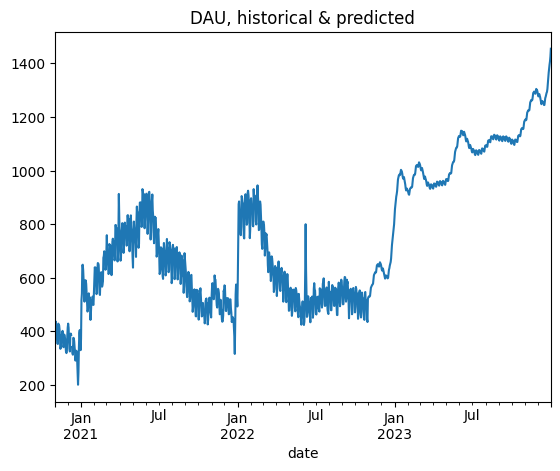

In [22]:
#| code-fold: true
#| code-summary: Toggle the code

pd.concat([dau_true['dau'], dau_pred['dau']])\
    .plot(title='DAU, historical & predicted');

And here we see that the prediction seems quite suspicious. It's not clear why the DAU is going up that high while the historical data didn't show the uptrend. We'll discuss it in the next section.

## 4. Model evaluation

### 4.1 General evaluation

First of all, let's test our model on historical data choosing two prediction periods: `2022-03-01` - `2022-10-31` and `2022-07-01` - `2022-10-31`. As for the transitions period, so far we consider full history from `DATASET_START` to `DATASET_END`.

In [31]:
#| code-fold: true
#| code-summary: Toggle the code

import re
from sklearn.metrics import mean_absolute_percentage_error


def make_prediction(prediction_start, prediction_end, new_users, mode='last_30d'):
    prediction_start_minus_1d = pd.to_datetime(prediction_start) - pd.Timedelta('1d')
    state0 = get_state0(prediction_start_minus_1d)

    if mode.startswith('last_'):
        shift = int(re.search(r'last_(\d+)d', mode).group(1))
        transitions_start = pd.to_datetime(prediction_start) - pd.Timedelta(shift, 'd')
        M = get_transition_matrix(transitions, transitions_start, prediction_start_minus_1d)
        dau_pred = predict_dau(M, state0, prediction_start, prediction_end, new_users)
    else:
        transitions_start = pd.to_datetime(prediction_start) - pd.Timedelta(30, 'd')
        M_last_month = get_transition_matrix(transitions, transitions_start, prediction_start_minus_1d)
        dau_pred = pd.DataFrame()

        month_starts = pd.date_range(prediction_start, prediction_end, freq='1MS')
        N = len(month_starts)

        for i, prediction_month_start in enumerate(month_starts):
            prediction_month_end = pd.offsets.MonthEnd().rollforward(prediction_month_start)
            transitions_month_start = prediction_month_start - pd.Timedelta('365D')
            transitions_month_end = prediction_month_end - pd.Timedelta('365D')

            M_seasonal = get_transition_matrix(transitions, transitions_month_start, transitions_month_end)
            if mode == 'smoothing':
                i = min(i, 12)
                M = M_seasonal * i / (N - 1)  + (1 - i / (N - 1)) * M_last_month
            elif mode == 'seasonal_0.1':
                M = 0.1 * M_seasonal + 0.9 * M_last_month
            
            dau_tmp = predict_dau(M, state0, prediction_month_start, prediction_month_end, new_users_pred)
            dau_pred = pd.concat([dau_pred, dau_tmp])

            state0 = dau_tmp.loc[prediction_month_end][states_order]

    return dau_pred

def prediction_details(dau_true, dau_pred, show_plot=True):
    y_true = dau_true.reindex(dau_pred.index)['dau']
    y_pred = dau_pred['dau']
    mape = mean_absolute_percentage_error(y_true, y_pred) 

    if show_plot:
        y_true.plot(label='DAU true')
        y_pred.plot(label='DAU pred')
        prediction_start = str(y_true.index.min().date())
        prediction_end = str(y_true.index.max().date())
        plt.title(f'DAU prediction, {prediction_start} - {prediction_end}')
        plt.legend()

    return mape


MAPE: 0.0681


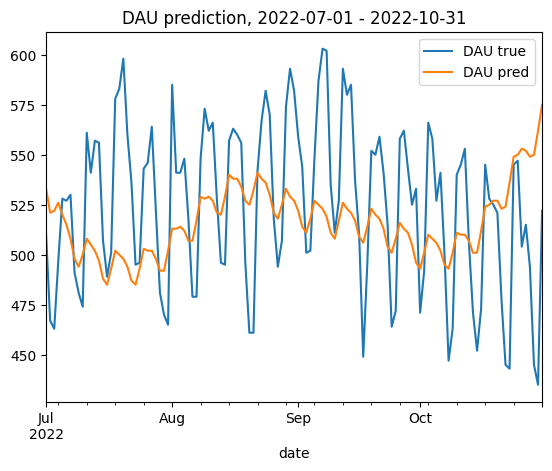

In [24]:
dau_pred = make_prediction('2022-07-01', '2022-10-31', new_users_pred, mode='last_365d')
mape = prediction_details(dau_true, dau_pred)
print(f'MAPE: {mape:.4f}')

MAPE: 0.0874


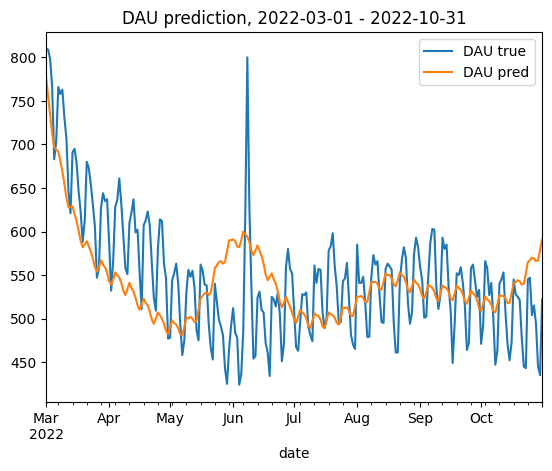

In [25]:
dau_pred = make_prediction('2022-03-01', '2022-10-31', new_users_pred, mode='last_365d')
mape = prediction_details(dau_true, dau_pred)
print(f'MAPE: {mape:.4f}')

MAPE: 0.1764


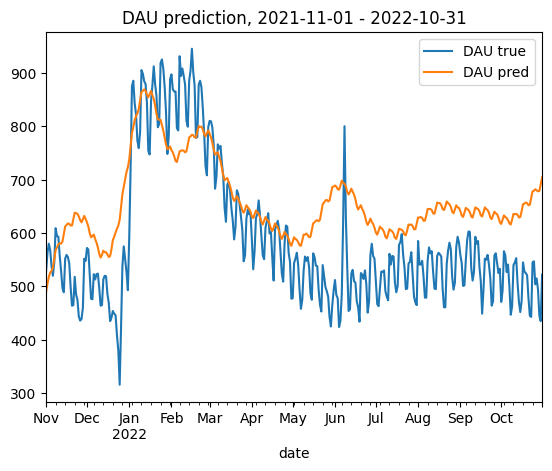

In [26]:
dau_pred = make_prediction('2021-11-01', '2022-10-31', new_users_pred, mode='last_365d')
mape = prediction_details(dau_true, dau_pred)
print(f'MAPE: {mape:.4f}')

We notice multiple things.
- While the MAPE values in both cases are reasonable (6-10%), the model doesn't capture trends well.
- The transition period matters. In the second case we see that from the beginning the predicted values are substantially lowen than the true values. It means that the transition matrix supposes that the users are less likely to retain that they are in reality.
- The trend changes are caused by the new users prediction.
- The predicted values are of less variance than the real DAU values. It's explained by the fact that the model doesn't consider weekly seasonality at all (i.e. day of week).
- A huge spike in the beginning of June obviously relates to some unexpected activity -- probably marketing. We'll explore it further.

Since the transition matrix is fixed for the whole prediction period, the only thing that can affect the trend changes is the variation in the new users prediction. Let's plot the `new_users_pred` time-series for the corresponding period.

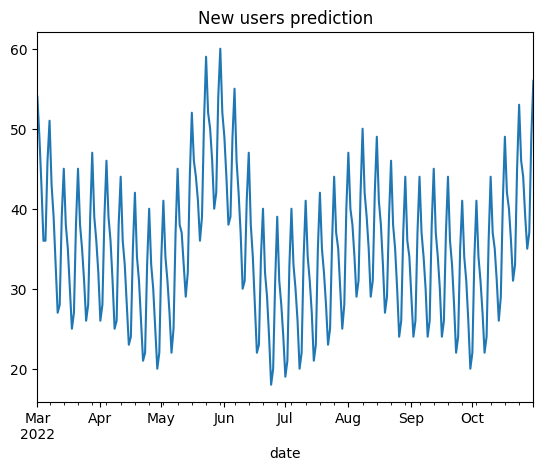

In [27]:
new_users_pred.loc['2022-03-01':'2022-10-31']\
    .plot(title='New users prediction');

It's clear now that the predicted DAU trend changes coincide with the new users prediction trend changes.

Now, let's decompose the prediction error and see which states contribure the most.

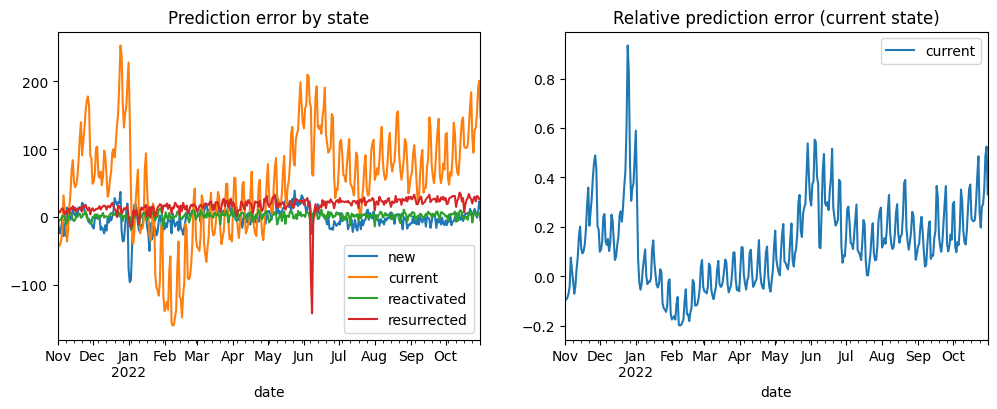

In [28]:
#| code-fold: true
#| code-summary: Toggle the code

dau_component_cols = ['new', 'current', 'reactivated', 'resurrected']

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

dau_pred[dau_component_cols]\
    .subtract(dau_true[dau_component_cols])\
    .reindex(dau_pred.index)\
    .plot(title='Prediction error by state', ax=ax1)

dau_pred[['current']]\
    .subtract(dau_true[['current']])\
    .div(dau_true[['current']])\
    .reindex(dau_pred.index)\
    .plot(title='Relative prediction error (current state)', ax=ax2);

First, we note that the error for new, reactivated, and resurrected states is quite low while for the current state is high. Unsurprisingly, this is because the current state contributes to DAU the most. As for the spike in July, we see now that it was caused my some CRM activity bacuse the corresponding spike occured particularly in the resurrected state.

Analysing relative errors for all the states seems to be not too informative, especially for the `reactivated` and `resurrected` states: their daily values are quite low, so the error appears to be to high and noisy. On the right diagram we see the relative error for the current state only. This error varies between -20% and 20% which we personally consider as high. And since the error of the `new` state is low, it can be explained only by the fact that the fixed transition matrix poorly describes user activity in the prediction period.

### 4.2 Transitions period impact

Here we're going to estimate how long a period before the prediction date should be considered to calculate the transition matrix values. We fix the same prediction period `2022-03-01` - `2022-10-31` and vary the transitions period: from 1 week to 1 year. In order to mitigate the noice from the new users prediction, we use the real values of the new users amount.

<Axes: title={'center': 'MAPE by shift'}, xlabel='shift'>

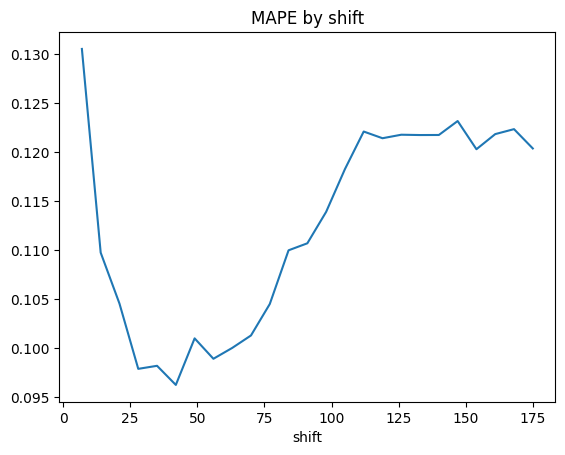

In [29]:
#| code-fold: true
#| code-summary: Toggle the code

prediction_period_start = '2022-03-01'
prediction_period_end = '2022-10-31'

result = []
for shift in range(7, 180, 7):
    dau_pred = make_prediction(prediction_period_start, prediction_period_end, new_users, mode=f'last_{shift}d')
    mape = prediction_details(dau_true, dau_pred, show_plot=False)
    result.append([shift, mape])
result = pd.DataFrame(result, columns=['shift', 'mape'])

result.set_index('shift')['mape']\
    .plot(title='MAPE by shift')

As we see, the MAPE curve has U-shape. This is quite clear: too short period can't capture signal from the most recent users while too long period is too genral and captures signal that is not valid anymore. Hence, the optimal transitions period is 4-7 weeks.

### 4.3 Obsolence and sesonality

Nevertheless, fixing a single transition matrix for predicting the whole year ahead doesn't seem to be a good idea: such a model would be too rigid. Usually, the user behavior varies depending on a season when a user comes in for the first time. For example, the users who appear after Christmas are of a different type: they could be more motivated to use an app or whatever else. In this section, to predict DAU in some prediction period we will also consider a transition matrix $M_{seasonal}$ from the corresponding period in the past. We consider three configurations:

- `last_30d`: the transition matrix is calculated from the last 30 days of the training data.
- `seasonal_0.1`: $M = 0.1 \cdot M_{seasonal} + 0.9 \cdot M_{last\_30d}$.
- `smoothing`: $M = \frac{i}{N - 1} M_{seasonal} + (1 - \frac{i}{N - 1}) M_{last\_30d}$ where $N$ is the number of months in the predicting period, $i = 0, \ldots, N - 1$ -- the month index. The idea of this configuration is to gradually switch from the most recent transition matrix to the seasonal one.

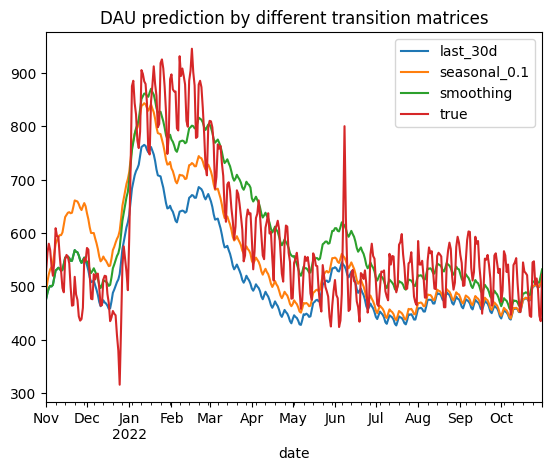

In [32]:
#| code-fold: true
#| code-summary: Toggle the code

result = pd.DataFrame()
for mode in ['last_30d', 'seasonal_0.1', 'smoothing']:
    result[mode] = make_prediction('2021-11-01', '2022-10-31', new_users_pred, mode)['dau']
result['true'] = dau_true['dau']
result['true'] = result['true'].astype(int)
result.plot(title='DAU prediction by different transition matrices');

In [33]:
#| code-fold: true
#| code-summary: Toggle the code

mape = pd.DataFrame()
for col in result.columns:
    if col != 'true':
        mape.loc[col, 'mape'] = mean_absolute_percentage_error(result['true'], result[col])
mape

,mape
last_30d,0.136540
seasonal_0.1,0.127246
smoothing,0.093658


According to the MAPE values, `smoothing` configuration provides the best results. The `seasonal_0.1` option demonstrates a bit better results than the `last_30d` one. Perhaps, it could be improved by chossing weight other than 0.1.

Interestingly, we notice how the difference between the predicted time-series of different configurations decays as the prediction period increases. It means that the impulse from the most recent $M_{last\_30d}$ matrix fades away and by the year, so that the DAU prediction is detrimented by the new users prediction and the transition matrix, converged and outdated.

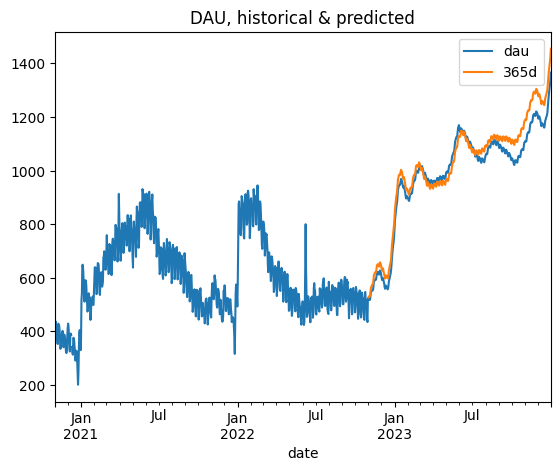

In [38]:
#| code-fold: true
#| code-summary: Toggle the code

dau_pred = make_prediction(PREDICTION_START, PREDICTION_END, new_users_pred, mode='smoothing')
dau_pred2 = make_prediction(PREDICTION_START, PREDICTION_END, new_users_pred, mode='last_365d')
pd.concat([dau_true['dau'], dau_pred['dau']]).plot(title='DAU, historical & predicted')
dau_pred2['dau'].plot(label='365d')
plt.legend();

## Discussion

Modeling DAU with Markov chain model seems 

## Conclusions

